<div align='center'>

# **Streaming K‐Means Clustering Pipeline**

**Author**: Vraj Shah

</div>

## Objective

The objective of this assignment is to build and evaluate a **Streaming K‐Means** clustering pipeline using PySpark. We will first review the standard (batch) K‐Means algorithm—its assumptions, steps, and limitations—then introduce the streaming variant, which processes data in mini‐batches and incrementally updates cluster centroids. By the end of this exercise, you should understand:

1. How standard K‐Means partitions a fixed dataset into k clusters by iteratively updating centroids to minimize within‐cluster variance.
2. Why standard K‐Means does not scale to unbounded data streams or handle concept drift.
3. How **Streaming K‐Means** (a weighted incremental version) updates centroids on each incoming micro‐batch, using a decay factor to “forget” old data gradually.
4. The differences in initialization, update rules, and evaluation between batch and streaming K‐Means.

### Standard (Batch) K‐Means

- **Problem setup:**
  Given a fixed dataset $X = \{x_1, \dots, x_n\}$ in $\mathbb{R}^d$ and a user-defined number of clusters $k$, the goal is to find centroids $\{\mu_1, \dots, \mu_k\}$ that minimize the within-cluster sum of squared distances:  
  $$
  \text{Objective:} \quad \sum_{i=1}^n \min_{j \in \{1,\dots,k\}} \| x_i - \mu_j \|^2
  $$
- **Algorithm steps:**
  1. **Initialization:** Choose \(k\) initial centroids (e.g., via random sampling or K‐Means++).  
  2. **Assignment:** Assign each point $x_i$ to the nearest centroid $\mu_j$ .  
  3. **Update:** For each cluster \(j\), recompute the centroid as the mean of all points assigned to \(j\).  
  4. **Iterate:** Repeat assignment and update until convergence (centroids stabilize or max iterations reached).  
- **Limitations:**  
  - Requires multiple passes over the entire dataset—impractical for data that arrives continuously.  
  - Cannot adapt if the underlying distribution shifts over time (“concept drift”).  
  - If the dataset is too large to fit in memory, you need multiple distributed passes, which is expensive.

### Streaming K‐Means

- **Setup:** Data arrives in a stream (e.g., from Kafka, file source, or a continuously growing RDD). We break the stream into **micro‐batches** of size \(b\) (e.g., 1000 points).  
- **Key idea:**
Maintain $k$ centroids $\mu_j^{(t)}$ and effective counts $N_j^{(t)}$ at time $t$. For each incoming batch $B_t$:
1. **Compute batch statistics** – Assign each point to its closest centroid and compute sum of vectors and count per cluster  
2. **Update centroids** – Use exponential decay to merge new stats with past values using a decay factor $\lambda \in [0, 1]$.
3. **Update Rule:**
For cluster $j$ with previous centroid $\mu_j^{(t-1)}$ and count $N_j^{(t-1)}$, and batch contribution $(S_j^{(t)}, n_j^{(t)})$, the updated values are:
$$
\mu_j^{(t)} = \frac{\lambda N_j^{(t-1)} \mu_j^{(t-1)} + S_j^{(t)}}{\lambda N_j^{(t-1)} + n_j^{(t)}}
$$
$$
N_j^{(t)} = \lambda N_j^{(t-1)} + n_j^{(t)}
$$
4. **Streaming loop:** Repeat for each micro‐batch. This yields a one‐pass, incremental clustering that can adapt to drifting distributions.

### Differences Between Batch and Streaming

- **Data access:** Batch K‐Means revisits all points until convergence; Streaming K‐Means processes each point exactly once (per micro‐batch) and updates centroids on the fly.  
- **Adaptivity:** Batch K‐Means finds a static partition for a fixed dataset; Streaming K‐Means can adapt to distributional changes by setting $\lambda < 1$.  
- **Computation:** Batch requires multiple passes (expensive on large/distributed data); Streaming demands only one pass per batch and constant memory for centroids.  
- **Use cases:** Batch suits offline analysis when data is static; Streaming K‐Means is ideal for real‐time clustering, online analytics, and concept‐drift scenarios (e.g., monitoring sensor readings, clickstreams, or bike‐sharing usage over time).

### Libraries Used

The following Python libraries are used throughout this streaming pipeline:

- **pandas** (`import pandas as pd`):  
  For loading and manipulating the CSV dataset in a tabular format.

- **numpy** (`import numpy as np`):  
  For efficient numerical computations, such as vector math and array transformations.

- **matplotlib.pyplot** (`import matplotlib.pyplot as plt`):  
  For plotting Batch SSE, Test SSE, and centroid trajectory visualizations.

- **sklearn.preprocessing.StandardScaler** (`from sklearn.preprocessing import StandardScaler`):  
  To normalize the input features (mean = 0, std = 1) before clustering.

- **pyspark.SparkContext** (`from pyspark import SparkContext`):  
  To initialize the Spark environment and create RDDs for distributed processing.

- **pyspark.streaming.StreamingContext** (`from pyspark.streaming import StreamingContext`):  
  To simulate a streaming context where RDDs are processed in micro-batches.

- **pyspark.mllib.clustering.StreamingKMeans** (`from pyspark.mllib.clustering import StreamingKMeans`):  
  For performing streaming K-Means clustering with model updates on each micro-batch.

- **pyspark.mllib.linalg.Vectors** (`from pyspark.mllib.linalg import Vectors`):  
  To convert NumPy arrays into Spark-compatible dense vector format for use in clustering.



```mermaid
graph TB

subgraph SP[Setup Streaming]
SA
end

SA[Staring Spark]

subgraph DP[Data Preparation]
LD
PD
SD
end

LD[Load Data]
PD[Preprocess Data]
SD[Split Data]

subgraph SK[Streaming Kmeans]
MI
CR
end

MI[Model Initialization]
CR[Create RDD Queue]

subgraph SU[Streaming Update]
CC
AC
TR
end
CC[Clustering Costs]
AC[Assign Clusters]
TR[Stream and Train]

subgraph SC[Streaming Context]
RS
end
RS[Run Streaming]

subgraph EV[Evaluation and Visualization]
RR
PB
PT
PC
end
RR[Collect Results]
PB[Plot Batch SSE]
PT[Plot Test SSE]
PC[Plot Centroid Trajectory]

subgraph SB[Stopping Spark]
ST
end
ST[Stop Spark]

SA --> LD
LD --> PD
PD --> SD
SD --> MI
MI --> CR
CR --> CC
CC --> AC
AC --> TR
TR --> RS
RS --> RR
RR --> PB
RR --> PT
RR --> PC
PB --> ST
PT --> ST
PC --> ST
classDef titleClass white-space:nowrap,z-index:2,color:red;
```

``````

# Index
- [Task SP: Setup Streaming](#task-SP)
  - [Subtask SP.1: Staring Spark](#task-SP-subtask-1)
- [Task DP: Data Preparation](#task-DP)
  - [Subtask DP.1: Load Data](#task-DP-subtask-1)
  - [Subtask DP.2: Preprocess Data](#task-DP-subtask-2)
  - [Subtask DP.3: Split Data](#task-DP-subtask-3)
- [Task SK: Streaming Kmeans](#task-SK)
  - [Subtask SK.1: Model Initialization](#task-SK-subtask-1)
  - [Subtask SK.2: Create RDD Queue](#task-SK-subtask-2)
- [Task SU: Streaming Update](#task-SU)
  - [Subtask SU.1: Clustering Costs](#task-SU-subtask-1)
  - [Subtask SU.2: Assign Clusters](#task-SU-subtask-2)
  - [Subtask SU.3: Stream and Train](#task-SU-subtask-3)
- [Task SC: Streaming Context](#task-SC)
  - [Subtask SC.1: Run Streaming](#task-SC-subtask-1)
- [Task EV: Evaluation and Visualization](#task-EV)
  - [Subtask EV.1: Collect Results](#task-EV-subtask-1)
  - [Subtask EV.2: Plot Batch SSE](#task-EV-subtask-2)
  - [Subtask EV.3: Plot Test SSE](#task-EV-subtask-3)
  - [Subtask EV.4: Plot Centroid Trajectory](#task-EV-subtask-4)
- [Task SB: Stopping Spark](#task-SB)
  - [Subtask SB.1: Stop Spark](#task-SB-subtask-1)


### Task 1: Setup Streaming <a id='task-1'></a>

Initialize the SparkSession and SparkContext.


#### Subtask 1.1: Staring Spark <a id='task-1-subtask-1'></a>

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import time
from collections import defaultdict
from sklearn.preprocessing import StandardScaler
from pyspark import SparkContext
from pyspark.streaming import StreamingContext
from pyspark.mllib.clustering import StreamingKMeans
from pyspark.mllib.linalg import Vectors

Initialize a PySpark environment by building a SparkSession, which serves as the primary entry point for DataFrame and Dataset APIs.
A SparkSession automatically creates or reuses an underlying SparkContext (sc), which manages the cluster resources, job scheduling, and distributed execution of RDD transformations and actions.

- **SparkSession (spark):**  
  Acts as the unified entry point for reading data, creating DataFrames, and executing SQL queries. It encapsulates configuration details (master URL, application name, memory settings, etc.) and provides convenient methods (`read`, `createDataFrame`, `sql`, etc.) for high‐level data processing.

- **SparkContext (sc):**  
  Under the hood, SparkSession instantiates a SparkContext that coordinates with the cluster manager (e.g., local threads, YARN, or Mesos). SparkContext is responsible for:
  1. **Resource Allocation:** Requesting executors or worker threads across the cluster.  
  2. **Task Scheduling:** Breaking down RDD transformations into stages and tasks, then distributing them to executors.  
  3. **Communication:** Managing shuffle and broadcast of variables (e.g., broadcasted centroids) for efficient distributed computation.

By calling `SparkSession.builder.appName(app_name).getOrCreate()`, we bootstrap the Spark application, register the app with the cluster manager, and return both:
  - `sc`: a SparkSession object for DataFrame and SQL operations  
  - `ssc`: the corresponding SparkContext for lower‐level RDD manipulations  
This setup is essential for the downstream streaming K‐Means pipeline, as we use SparkContext to create RDDs, broadcast variables (centroids), and perform distributed aggregate operations on micro‐batches.


In [2]:
def setup_streaming_context(app_name="StreamingKMeansExample", batch_duration=1):
    """Create SparkSession and SparkContext
    input: app_name, str, Name of the Spark application
    input: batch_duration, int, Duration of each micro-batch in the streaming context, Default: 1
    output: sc, SparkContext, SparkContext used for creating RDDs and managing Spark jobs
    output: ssc, StreamingContext, PySpark Streaming context for processing RDD queue
    """

    sc = SparkContext(appName=app_name)
    ssc = StreamingContext(sc, batchDuration=batch_duration)

    return sc, ssc

### Task 2: Data Preparation <a id='task-2'></a>

Load, split, preprocess the bike‐sharing data.


#### Subtask 2.1: Load Data <a id='task-2-subtask-1'></a>

Use `pd.read_csv()` to load the CSV into memory.


In [3]:
def load_raw_data(file_path):
    """Read CSV into pandas DataFrame
    input: file_path, str, Path to the CSV dataset
    output: df, pandas DataFrame, Raw data loaded from CSV
    """

    """__Your_Code_Here__"""

    df = pd.read_csv(file_path)

    return df

#### Subtask 2.2: Preprocess Data <a id='task-2-subtask-2'></a>

Select the feature columns:
`["temp", "atemp", "hum", "windspeed", "casual", "registered"]` from the raw DataFrame,
fill missing values with 0, and standardize them using `sklearn.preprocessing.StandardScaler`
to produce a normalized NumPy array `X_scaled`.

This transformation ensures that each feature has zero mean and unit variance,
which improves clustering quality and stabilizes centroid updates in K-Means.

**Example Before Preprocessing (actual rows from hour.csv):**

| temp  | atemp  | hum  | windspeed | casual | registered |
|-------|--------|------|-----------|--------|------------|
| 0.24  | 0.2879 | 0.81 | 0.0000    | 3      | 13         |
| 0.22  | 0.2727 | 0.80 | 0.0000    | 8      | 32         |
| 0.22  | 0.2727 | 0.80 | 0.0000    | 5      | 27         |

**Example After Preprocessing (X_scaled NumPy Array):**

```
array([[-0.0923,  0.1441,  0.8701, -0.5546, -1.1338, -1.2186],
      [-0.4536, -0.2517,  0.8327, -0.5546, -0.0882,  0.0565],
      [-0.4536, -0.2517,  0.8327, -0.5546, -0.6110, -0.3602]])
```

Each row in `X_scaled` corresponds to a standardized feature vector,
ready for micro-batching and StreamingKMeans clustering.


In [4]:
def preprocess_data(df):
    """Assemble feature vector
    input: df, pandas DataFrame, Raw data loaded from CSV
    output: X_scaled, ndarray, Normalized feature matrix using StandardScaler
    """

    features = ['temp', 'atemp', 'hum', 'windspeed', 'casual', 'registered']

    """__Your_Code_Here__"""
    X = df[features].fillna(0)

    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)


    return X_scaled

#### Subtask 2.3: Split Data <a id='task-2-subtask-3'></a>

Split the standardized feature matrix `X_scaled` into training and test sets
using a simple index-based slice.

The `ratio` parameter defines the proportion of data to assign to the training set (default 0.8).
This operation is performed using NumPy slicing to ensure fast, local splitting
before converting to Spark RDDs.

**Split Logic:**
- Let N = number of rows in X_scaled  
- Let split_index = floor(ratio × N)  
- Assign rows 0 to (split_index - 1) to `train_X`  
- Assign rows split_index to (N - 1) to `test_X`

This results in:
- `train_X`: 80% of the rows used for streaming training
- `test_X`: 20% held out for evaluating test SSE after each batch


In [5]:
def train_test_split(X_scaled, ratio=0.8):
    """Train/test split (80/20)
    input: X_scaled, ndarray, Normalized feature matrix using StandardScaler
    input: ratio, float, Train-test split ratio, Default: 0.8
    output: train_X, ndarray, First 80 percent of X scaled used for training
    output: test_X, ndarray, Last 20 percent of X scaled used for evaluation
    """

    """__Your_Code_Here__"""
    N = X_scaled.shape[0]
    split_index = int(np.floor(ratio * N))

    train_X = X_scaled[:split_index]
    test_X = X_scaled[split_index:]


    return train_X, test_X

### Task 3: Streaming Kmeans <a id='task-3'></a>

This block covers two essential subtasks before streaming can begin:

1. **Model Initialization (MI):**  
  We create the `StreamingKMeans` model with a specified number of clusters, decay factor, and randomly initialized centroids. This provides the initial state for learning.

1. **RDD Queue Creation (CR):**  
  We simulate streaming by dividing the training data into multiple micro-batches and converting each batch into a Spark RDD. These are queued and processed one at a time.

Together, these subtasks prepare both the model and its input stream, enabling incremental updates as each batch arrives.


#### Subtask 3.1: Model Initialization <a id='task-3-subtask-1'></a>

This subtask sets up a `StreamingKMeans` model using PySpark’s `mllib.clustering` module.

Before training begins, we must instantiate the model with:
- A chosen number of clusters (`k`)
- A decay factor (`decay_factor`) that controls how much past batches influence the update
- Random initial cluster centers (via `np.random.randn`) of shape (`k`, `dim`)
- Uniform weights (ones) assigned to all clusters equally

The random seed ensures that initial center generation is deterministic and reproducible.

Behind the scenes:
- `StreamingKMeans.setInitialCenters()` accepts a matrix of cluster centers and a vector of weights.
- These are used to compute a weighted centroid update as each micro-batch arrives.
- The decay factor acts like a momentum term, giving less importance to older data.

⚠️ **Note:**
- Always set `k = 3` as per assignment instructions.
- To get the correct `dim`, pass `X_scaled.shape[1]` — this ensures centroids match the number of input features.


In [6]:
def initialize_model(k, dim, decay_factor=0.8, seed=42):
    """reate StreamingKMeans model with random centers
    input: k, int, Number of clusters for KMeans
    input: dim, int, Dimensionality of the input feature vectors
    input: decay_factor, float, Streaming decay factor for exponential forgetting, Default: 0.8
    input: seed, int, Random seed for initializing cluster centers (default 42), Default: 42
    output: model, StreamingKMeans, Streaming KMeans model that gets updated batch by batch
    """

    np.random.seed(seed)
    """__Your_Code_Here__"""
    initial_centers = np.random.randn(k, dim)
    initial_weights = np.ones(k)
    model = StreamingKMeans(k=k, decayFactor=decay_factor)
    model.setInitialCenters(initial_centers, initial_weights)


    return model

#### Subtask 3.2: Create RDD Queue <a id='task-3-subtask-2'></a>

In streaming applications, data arrives in small chunks over time. Since we're using static input (like a full NumPy array), this function manually breaks the `train_X` dataset into a series of fixed-size mini-batches. Each mini-batch is converted into a Spark RDD and added to a queue that mimics a real-time stream.

Here's what happens:
- The training data is traversed in steps of `batch_size`.
- Each subset of rows is extracted as a batch.
- That batch is converted into an RDD using the SparkContext.
- Each data point in the RDD is wrapped as a `DenseVector`, which is the format required by Spark MLlib clustering models.
- These RDDs are appended to a list (`rdd_queue`) that will be fed to the streaming pipeline via `ssc.queueStream(...)`.

This allows us to simulate how StreamingKMeans would behave with live data in production.

**Example:**

Suppose your training data `train_X` looks like this:
```
[
  [0.1, 0.2, 0.3],
  [0.4, 0.5, 0.6],
  [0.7, 0.8, 0.9],
  [1.0, 1.1, 1.2]
]
```

If you use `batch_size = 2`, the function will return a queue of two RDDs:
- Batch 1 contains the first two vectors
- Batch 2 contains the remaining two vectors

Each of these is processed sequentially by the Spark Streaming engine to simulate incoming data batches.


In [7]:
def create_rdd_queue(sc, train_X, batch_size):
    """Split train array into micro-batches and convert to RDDs
    input: sc, SparkContext, SparkContext used for creating RDDs and managing Spark jobs
    input: train_X, ndarray, First 80 percent of X scaled used for training
    input: batch_size, int, Number of points in each micro-batch
    output: rdd_queue, list[RDD[DenseVector]], List of RDDs simulating incoming streaming batches
    """

    """__Your_Code_Here__"""
    rdd_queue = []
    N = train_X.shape[0]

    for start in range(0, N, batch_size):
        end = start + batch_size
        batch = train_X[start:end]
        batch_vectors = [Vectors.dense(row.tolist()) for row in batch]
        rdd = sc.parallelize(batch_vectors)
        rdd_queue.append(rdd)


    return rdd_queue

### Task 4: Streaming Update <a id='task-4'></a>

The **Streaming Update** phase is where the clustering model continuously adapts to new incoming micro-batches. As each mini-batch is processed, the model incrementally updates its cluster centroids based on the most recent data.

This stage ensures that the algorithm:
- Reacts to changes in data distribution over time (concept drift)
- Prioritizes newer data using a decay factor
- Records key performance metrics (like Batch SSE and Test SSE)
- Tracks the evolution of centroids for visualization and analysis

By the end of this phase, we have a dynamically updated clustering model and a full record of its performance and centroid movement over time.


#### Subtask 4.1: Clustering Costs <a id='task-4-subtask-1'></a>

This function computes the **total clustering cost** — the sum of squared distances between each point in the dataset and its **nearest centroid**.

Make sure to use np.array for calculations

##### What It Does:

For a given set of `centers` (NumPy arrays representing the cluster centroids) and a dataset `data` (2D NumPy array), the function:

1. Iterates over each data point $x$ in `data`.
2. For each point, calculates the squared Euclidean distance $\|x - \mu_j\|^2$ to all centroids $\mu_j$.
3. Selects the smallest such distance.
4. Adds it to a running sum representing the **clustering cost**.

##### Formula:

For every data point $x \in \mathbb{R}^d$, and $k$ cluster centers $\{\mu_1, \mu_2, \dots, \mu_k\}$, we compute:

$$
\text{cost} = \sum_{x \in \text{data}} \min_j \|x - \mu_j\|^2
$$

Where:
- $\|x - \mu_j\|^2 = \sum_{i=1}^d (x_i - \mu_{j,i})^2$ is the squared Euclidean distance.

##### Example:

Suppose:
- `centers = [[1.0, 3.0], [5.0, 1.0], [2.5, 4.5]]`
- `data = [[2.0, 4.0], [4.0, 2.0]]`

- For point $[2.0, 4.0]$:
  - Distance to center 0: $(2 - 1)^2 + (4 - 3)^2 = 1 + 1 = 2$
  - To center 1: $(2 - 5)^2 + (4 - 1)^2 = 9 + 9 = 18$
  - To center 2: $(2 - 2.5)^2 + (4 - 4.5)^2 = 0.25 + 0.25 = 0.5$
  - Nearest distance = **0.5**

- For point $[4.0, 2.0]$:
  - Closest center is 1 → squared distance = $(4 - 5)^2 + (2 - 1)^2 = 1 + 1 = 2$

**Total Cost** = $0.5 + 2 = 2.5$

This output helps us evaluate the quality of the current clustering: **lower cost indicates better cohesion**.


In [8]:
def clustering_cost(centers, data):
    """Total squared error from nearest centroids
    input: centers, list[ndarray], Final centroids output from the trained model
    input: data, ndarray, Array of input vectors to compute clustering cost against given centers
    output: cost, float, Final test SSE cost with learned cluster centers
    """

    """__Your_Code_Here__"""
    centers = np.array(centers)
    data = np.array(data)
    diff = data[:, None, :] - centers[None, :, :]
    sq_dists = np.sum(diff ** 2, axis=2)
    min_sq_dists = np.min(sq_dists, axis=1)
    cost = float(np.sum(min_sq_dists))

    return cost

#### Subtask 4.2: Assign Clusters <a id='task-4-subtask-2'></a>

This function assigns each point in the dataset to the nearest cluster center. It is typically used to produce final cluster assignments after training, or to evaluate how the model partitions a given dataset.

##### What It Does:

For every data point in the input `data`:
- Compute the squared Euclidean distance to each centroid in `centers`
- Identify the centroid with the smallest distance using `np.argmin`
- Assign the point to that cluster (by index)

The result is a list of tuples, where each element is:
- The index of the nearest centroid
- The original point (rounded) assigned to that centroid

##### Formula:

For each point $x$ and cluster centers $\{\mu_1, \mu_2, \dots, \mu_k\}$:

$$
j^* = \arg\min_j \|x - \mu_j\|^2
$$

The value $j^*$ is stored as the assignment for point $x$.

##### Example:

Suppose:
- `centers = [[1.0, 3.0], [5.0, 1.0], [2.5, 4.5]]`
- `data = [[2.0, 4.0], [4.0, 2.0]]`

For $[2.0, 4.0]$, closest center is at index 2  
For $[4.0, 2.0]$, closest center is at index 1  

Output: `[(2, [2.0, 4.0]), (1, [4.0, 2.0])]`

These assignments indicate the cluster index each point belongs to.

**Note:**  
Use `np.argmin` over the list of distances to efficiently determine the closest centroid.


In [9]:
def assign_clusters(centers, data):
    """Assign each point to nearest centroid
    input: centers, list[ndarray], Final centroids output from the trained model
    input: data, ndarray, Array of input vectors to compute clustering cost against given centers
    output: assignments, list[tuple[int, list[float]]], Final assignment of test points to nearest clusters
    """

    """__Your_Code_Here__"""
    centers = np.array(centers)
    data = np.array(data)

    diff = data[:, None, :] - centers[None, :, :]
    sq_dists = np.sum(diff ** 2, axis=2)

    nearest_idx = np.argmin(sq_dists, axis=1)

    assignments = [
        (int(idx), np.round(point, 4).tolist())
        for idx, point in zip(nearest_idx, data)
    ]


    return assignments

#### Subtask 4.3: Stream and Train <a id='task-4-subtask-3'></a>

This function connects the streaming data pipeline to the clustering model and collects evaluation metrics over time.

##### What It Does:

It defines a **nested function** called `track_stats(time, rdd)` which gets invoked automatically by Spark for each mini-batch (as an RDD). This allows us to analyze each batch during streaming without materializing the entire dataset in memory.

**Inside `track_stats`:**
- Collects the RDD and checks if it contains any data.
- Retrieves the current cluster centers from the model.
- Computes:
  - **Batch SSE**: clustering error on the incoming batch.
  - **Test SSE**: clustering error on the held-out test set.
- Stores these statistics for plotting or analysis.
- Appends the latest cluster centers to a history list for trajectory visualization.

Finally, the outer function:
- Attaches `track_stats` to every batch in the stream using `foreachRDD`.
- Triggers model training on the same stream using `.trainOn(...)`.

##### Why This Matters:

- Spark executes in a distributed, lazy fashion. To inspect evolving metrics like SSE over time, we must collect relevant batch-level statistics inside an RDD processing function.
- Tracking both batch and test errors gives insight into convergence and concept drift during training.
- Capturing centroids over time enables trajectory plots of how clusters shift as more data arrives.

##### Example:

Suppose the first micro-batch contains:
```
RDD = [[0.1, 0.2], [0.5, 0.6]]
```
And the current cluster centers are:
```
[[0.0, 0.0], [1.0, 1.0]]
```
Then we compute:
- Distance of each point to each center
- Assign nearest center
- Compute sum of squared distances = Batch SSE
- Also compute SSE on the fixed `test_X` dataset

##### Pseudocode:

```python
def attach_stream_and_train(stream, model, test_X, ...):

    def track_stats(time, rdd):
        if rdd has points:
            centers = model.latestModel().centers
            record current centers
            compute batch SSE using clustering_cost(centers, batch)
            compute test SSE using clustering_cost(centers, test_X)
            append both to tracking lists

    stream.foreachRDD(track_stats)
    model.trainOn(stream)
```

This is a key monitoring step that ensures the streaming K-Means is not just running, but learning and adapting effectively.


In [10]:
def attach_stream_and_train(stream, model, test_X, batch_sse_list, test_sse_list, centroids_history):
    """Track and update clustering performance over time
    input: stream, DStream, Streaming queue of RDD batches to be processed
    input: model, StreamingKMeans, Streaming KMeans model that gets updated batch by batch
    input: test_X, ndarray, Last 20 percent of X scaled used for evaluation
    input: batch_sse_list, list[float], Per-batch sum of squared errors over training batches
    input: test_sse_list, list[float], SSE of the current model on the test data after each batch
    input: centroids_history, list[list[ndarray]], History of cluster centers after each micro-batch
    output: None
    """

    """__Your_Code_Here__"""

    def track_stats(time, rdd):
      """__Your_Code_Here__"""
      batch = rdd.collect()
      if not batch:
        return

      batch_np = np.array([v.toArray() for v in batch])

      centers = model.latestModel().centers

      centroids_history.append([c.copy() for c in centers])

      batch_sse = clustering_cost(centers, batch_np)
      batch_sse_list.append(batch_sse)

      test_sse = clustering_cost(centers, test_X)
      test_sse_list.append(test_sse)


    stream.foreachRDD(track_stats)
    model.trainOn(stream)

    return None

### Task 5: Streaming Context <a id='task-5'></a>

This module controls the lifecycle of the **Spark Streaming job**. It starts the `StreamingContext` to process micro-batches in real time and stops it once processing is complete or the timeout is reached.

Properly managing the `StreamingContext` ensures the streaming pipeline runs smoothly and exits gracefully — preventing resource leaks or dangling jobs.


#### Subtask 5.1: Run Streaming <a id='task-5-subtask-1'></a>

Launches the Spark Streaming process using:

- `ssc.start()` to begin reading and processing RDD batches from the stream
- `ssc.awaitTerminationOrTimeout(timeout)` to keep it alive for a fixed duration
- `ssc.stop(stopSparkContext=False)` to stop the streaming context once the timeout is reached or the job is completed

The `timeout` parameter controls how long (in seconds) the streaming job stays active. Use `timeout = 80` or a value where all batches results are processed,  by default unless you intend to stream indefinitely.


In [11]:
def run_streaming(ssc, timeout=80):
    """Start and run StreamingContext
    input: ssc, StreamingContext, PySpark Streaming context for processing RDD queue
    input: timeout, int, Duration (in seconds) to run the streaming job before automatic termination
    output: None
    """

    ssc.start()
    ssc.awaitTerminationOrTimeout(timeout)
    ssc.stop(stopSparkContext=False)

    return None

#### Subtask 5.2: Stop Streaming <a id='task-5-subtask-2'></a>

Gracefully halts the streaming execution using `ssc.stop(...)`.

This function ensures that all micro-batches currently in progress are completed, and then the streaming job is terminated. Use this after `run_streaming` to shut down streaming logic before stopping the Spark cluster itself.


In [12]:
def stop_streaming(ssc):
    """Stop the StreamingContext
    input: ssc, StreamingContext, PySpark Streaming context for processing RDD queue
    output: None
    """

    ssc.stop(stopSparkContext=False)

    return None

### Task 6: Evaluation and Visualization <a id='task-6'></a>

After the streaming K-Means pipeline completes, this phase evaluates the clustering performance and visualizes the learning dynamics across micro-batches.

#### Core Objectives:

- **Metric Collection**:  
  Measure clustering quality at each step using:
    - **Batch SSE**: Sum of squared distances within clusters on each micro-batch.
    - **Test SSE**: SSE computed on a static hold-out test set to monitor generalization.

- **Trend Visualization**:  
  Plot the recorded metrics and centroid movements to understand how the model evolved:
    1. **Batch SSE vs Batch Index** – Monitors convergence and clustering tightness per batch.
    2. **Test SSE vs Batch Index** – Evaluates whether generalization is improving or degrading.
    3. **Centroid Trajectories** – Visualizes how cluster centers shift over time, indicating convergence or concept drift.

This phase helps:
- Validate that the model is learning meaningful cluster structures.
- Detect problems like poor convergence, instability, or overfitting.
- Provide interpretable visuals for analysis and reporting.


#### Subtask 6.1: Collect Results <a id='task-6-subtask-1'></a>

This task gathers evaluation metrics for each micro-batch during streaming by tracking clustering performance.

#### What It Does:

- **Retrieve Model State**:  
  Get the current centroids from the latest version of the streaming model using `model.latestModel().centers`.

- **Track Centroid History**:  
  Convert each centroid to a NumPy array and append it to `centroids_history` to monitor movement over time.

- **Compute Evaluation Metrics**:
  Calculate all five of the following:
    1. **Final Cluster Centers** – list of lists
    2. **Assignments** – predicted cluster index for each test point using `assign_clusters()`
    3. **Final Test SSE** – clustering_cost on `test_X` with latest centers
    4. **Batch SSE List** – historical SSE per batch
    5. **Test SSE List** – SSE over test set per batch

- **Use Helper Functions**:  
  Call:
    - `assign_clusters()` to match test points to nearest centroids.
    - `clustering_cost()` to calculate SSE for both streaming batches and test data.

#### Example Output:
```json
{
  "centers": [
    [0.1234, -0.5678, 0.3456],
    [-0.8765, 0.4321, -0.1234],
    [0.6789, 0.0123, 0.4567]
  ],
  "assignments": [1, 0, 2, 2, 1],
  "cost": 12.34,
  "batch_sse_list": [15.22, 14.11, 13.89, 12.76, 12.34],
  "test_sse_list": [20.15, 18.43, 17.56, 13.88, 12.34]
}
```


In [13]:
def collect_results(model, test_X, batch_sse_list, test_sse_list, centroids_history):
    """Sum of squared errors across streaming iterations
    input: model, StreamingKMeans, Streaming KMeans model that gets updated batch by batch
    input: test_X, ndarray, Last 20 percent of X scaled used for evaluation
    input: batch_sse_list, list[float], Per-batch sum of squared errors over training batches
    input: test_sse_list, list[float], SSE of the current model on the test data after each batch
    input: centroids_history, list[list[ndarray]], History of cluster centers after each micro-batch
    output: results, dict, Dictionary holding final output
    """

    """__Your_Code_Here__"""
    final_centers = model.latestModel().centers
    final_centers_np = [c.tolist() for c in final_centers]

    final_test_sse = clustering_cost(final_centers, test_X)

    assignments = assign_clusters(final_centers, test_X)

    results = {
        "centers": final_centers_np,
        "assignments": assignments,
        "cost": final_test_sse,
        "batch_sse_list": batch_sse_list,
        "test_sse_list": test_sse_list,
        "centroids_history": centroids_history
    }


    return results

#### Subtask 6.2: Plot Batch SSE <a id='task-6-subtask-2'></a>

This function visualizes the convergence behavior of the model by plotting the
**Sum of Squared Errors (SSE)** for each micro-batch.

#### What it does:
- Convert `batch_sse_list` into a DataFrame or use list indexing directly.
- Plot a line graph of `batch_index` (x-axis) vs. `batch_sse` (y-axis).
- Use appropriate axis labels and titles to highlight trends.

This helps identify whether the model is learning over time — a decreasing SSE implies tighter clusters.


In [14]:
def plot_batch_sse(batch_sse_list):
    """Line‐plot of batch SSE over time
    input: batch_sse_list, list[float], Per-batch sum of squared errors over training batches
    output: None
    """



    plt.figure(figsize=(8, 4))
    """__Your_Code_Here__"""
    batches = list(range(len(batch_sse_list)))
    plt.plot(batches, batch_sse_list, marker='o')
    plt.title("Batch SSE")
    plt.xlabel("Batch")
    plt.ylabel("SSE")
    plt.grid(True)
    plt.show()

    return None

#### Subtask 6.3: Plot Test SSE <a id='task-6-subtask-3'></a>

This function evaluates generalization performance of the model after each batch update.

#### What it does:
- Convert `test_sse_list` into a DataFrame or indexed list.
- Plot a line graph of `batch_index` vs. `test_sse`.
- Add axis labels, title, and grid to clearly communicate the trend.

A rising test SSE with a falling batch SSE may indicate overfitting or poor generalization.


In [15]:
def plot_test_sse(test_sse_list):
    """Line‐plot of test SSE over time
    input: test_sse_list, list[float], SSE of the current model on the test data after each batch
    output: None
    """



    plt.figure(figsize=(8, 4))
    """__Your_Code_Here__"""
    batches = list(range(len(test_sse_list)))
    plt.plot(batches, test_sse_list, marker='o')

    plt.title("Test SSE")
    plt.xlabel("Batch")
    plt.ylabel("SSE")
    plt.grid(True)
    plt.show()

    return None

#### Subtask 6.4: Plot Centroid Trajectory <a id='task-6-subtask-4'></a>

This visualization shows how each cluster’s centroid **moves across streaming updates**,
revealing adaptation and convergence over time.

#### What it does:
- For each cluster, extract its centroid's coordinates from all batches.
- Plot the first two dimensions (e.g., features 0 and 1) as a 2D path.
- Optionally, add arrows or markers to indicate direction of movement.

This provides an intuitive view of whether centroids stabilize or continue shifting — a sign of concept drift.


In [16]:
def plot_centroid_trajectories(centroids_history):
    """2D projection of centroid paths
    input: centroids_history, list[list[ndarray]], History of cluster centers after each micro-batch
    output: None
    """

    if not centroids_history:
        print("No centroid history recorded.")
        return
    plt.figure(figsize=(6, 6))
    K = len(centroids_history[0])
    for k in range(K):
        """__Your_Code_Here__"""
        traj = np.array([batch[k] for batch in centroids_history])

        x = traj[:, 0]
        y = traj[:, 1]

        plt.plot(x, y, marker='o', label=f"Centroid {k}")

        for i in range(len(x) - 1):
            plt.arrow(x[i], y[i], x[i+1] - x[i], y[i+1] - y[i],
                      shape='full', head_width=0.02, length_includes_head=True, alpha=0.3)
    plt.title("Centroid Trajectories (2D projection)")
    plt.xlabel("Dimension 0")
    plt.ylabel("Dimension 1")
    plt.legend()
    plt.grid(True)
    plt.show()

    return None

### Task 7: Stopping Spark <a id='task-7'></a>

Cleanly shut down the SparkSession and SparkContext.


#### Subtask 7.1: Stop Spark <a id='task-7-subtask-1'></a>

Call `sc.stop()` to release resources and end the Spark application.

In [17]:
def stop_spark(sc):
    """Stop the SparkSession
    input: sc, SparkContext, SparkContext used for creating RDDs and managing Spark jobs
    output: None
    """

    """__Your_Code_Here__"""

    sc.stop()

    return None

/usr/local/lib/python3.12/dist-packages/pyspark/streaming/context.py:72: FutureWarning: DStream is deprecated as of Spark 3.4.0. Migrate to Structured Streaming.
  warnings.warn(



===== FINAL TEST SET SSE COST =====
Cost = 985032.76

Final Cluster Centers:
Cluster 0: [-0.3234805181759838, -0.090485550139435, 0.6406700772071171, 0.5668271846836234, 0.17765881764698138, 0.007625075456202743]
Cluster 1: [0.6078184588482772, 0.737099870884885, -0.25477411463331856, -0.23324335312099104, -0.013101649117781873, -0.1996939411292938]
Cluster 2: [-0.2804140135194556, -0.7516449054210925, -0.5681629516730008, -0.49411416522201845, -0.22255512673723654, 0.22356809936235789]

First 10 Test Assignments:
Data point assigned to Cluster 1: [-0.0371, 0.1663, 0.7411, -0.8133, -0.1359, -0.1237]
Data point assigned to Cluster 0: [0.4824, -0.3132, 1.9858, -0.0658, 1.5071, 1.0462]
Data point assigned to Cluster 0: [-1.6476, -1.907, 1.8302, -0.9213, 0.4524, -1.0888]
Data point assigned to Cluster 2: [1.3656, -1.1767, -0.5556, 0.0577, -0.0142, -1.1218]
Data point assigned to Cluster 2: [1.1578, -1.8506, 0.0668, 0.2147, 1.3448, 2.8375]
Data point assigned to Cluster 0: [-0.4527, -0.271

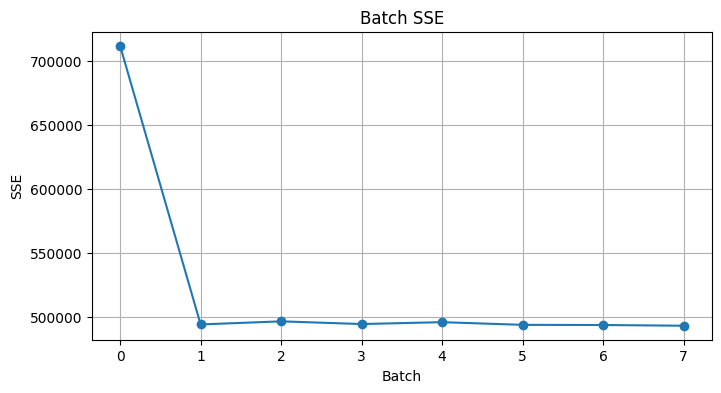

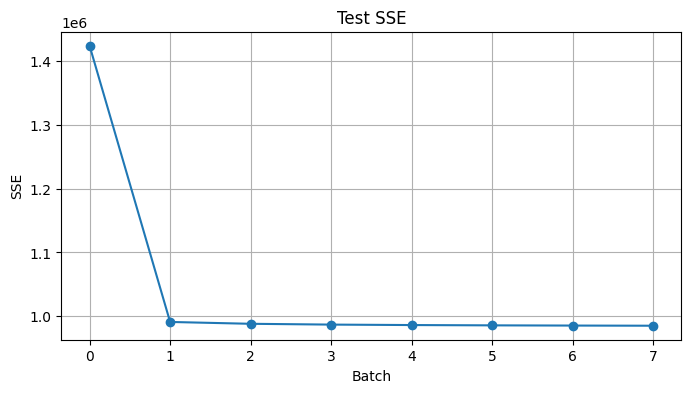

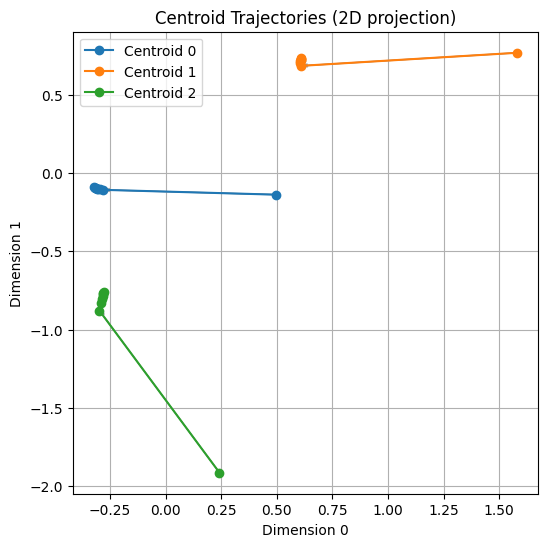

In [18]:
def main():
    df = load_raw_data("streaming_kmeans_1.csv")
    X_scaled = preprocess_data(df)
    train_X, test_X = train_test_split(X_scaled)

    batch_sse_list, test_sse_list, centroids_history = [], [], []

    sc, ssc = setup_streaming_context()
    model = initialize_model(k=3, dim=X_scaled.shape[1], decay_factor=0.8)

    rdd_queue = create_rdd_queue(sc, train_X, batch_size=100000)
    stream = ssc.queueStream(rdd_queue)

    attach_stream_and_train(stream, model, test_X, batch_sse_list, test_sse_list, centroids_history)
    run_streaming(ssc, timeout=80)
    stop_streaming(ssc)

    results = collect_results(model, test_X, batch_sse_list, test_sse_list, centroids_history)

    print(f"\n===== FINAL TEST SET SSE COST =====")
    print(f"Cost = {round(results['cost'], 2)}\n")

    print("Final Cluster Centers:")
    for idx, center in enumerate(results["centers"]):
        print(f"Cluster {idx}: {center}")

    print("\nFirst 10 Test Assignments:")
    for cluster, vec in results["assignments"][:10]:
        print(f"Data point assigned to Cluster {cluster}: {vec}")

    print("\nBatch SSE List:", results["batch_sse_list"])
    print("Test SSE List:", results["test_sse_list"])
    print("Centroid history length:", len(results["centroids_history"]))

    plot_batch_sse(results["batch_sse_list"])
    plot_test_sse(results["test_sse_list"])
    plot_centroid_trajectories(results["centroids_history"])

    stop_spark(sc)


# Entry point
if __name__ == "__main__":
    main()

## References

- [Spark Streaming K‐Means Documentation](https://spark.apache.org/docs/latest/ml-clustering.html#streaming-k-means)
- [Streaming KMeans in Spark | Real-time Clustering with PySpark (YouTube)](https://www.youtube.com/watch?v=N3Mfo880K54)
- [What is Streaming K-Means? (DSWorld)](https://dsworld.org/what-is-a-streaming-k-means/)
- [Online K-Means Clustering of Large High-Dimensional Data Streams (ICDE 2017)](https://www.ece.iastate.edu/snt/files/2017/08/kmeans-ICDE-2017.pdf)
- [Introducing Streaming K-Means in Spark 1.2 (Databricks Blog)](https://www.databricks.com/blog/2015/01/28/introducing-streaming-k-means-in-spark-1-2.html)
